# importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # for enhanced visualizations

# setting up the files path
- to be able to import the modules in the script folder

In [4]:
import sys
from pathlib import Path

scripts_path = Path('./scripts')
sys.path.append(str(scripts_path))

## importing the module

In [5]:
from ingestion import PostgreSQLConnection

## setting up the connection

In [69]:
db_config = {
        'dbname': 'digital_store_DWH',
        'user': 'postgres',
        'password': '123', # User postgres password
        'host': 'localhost',
        'port': 5432
    }
db_connection = PostgreSQLConnection(**db_config)
db_connection.connect()

Connected to the digital_store_DWH database!


#  getting **Revenue by month**

In [7]:
# use db_connection.execute_extract_query(---#add your query here-----)
# then transform it into a Pandas DataFrame!
MonthlyRevenue= db_connection.execute_extract_query(
"""SELECT DATE_TRUNC('month', invoice_date) AS Month, SUM(total) AS MonthlyRevenue
FROM dw_schema.invoice_details
GROUP BY Month
ORDER BY Month;""")
MonthlyRevenue=pd.DataFrame(MonthlyRevenue,columns=['month','MonthlyRevenue'])
MonthlyRevenue.head()

,month,MonthlyRevenue
0,2021-01-01,35.64
1,2021-02-01,37.62
2,2021-03-01,37.62
3,2021-04-01,37.62
4,2021-05-01,37.62


## transforming the data for plotting

In [8]:
MonthlyRevenue = MonthlyRevenue.set_index('month')
MonthlyRevenue.index = MonthlyRevenue.index.strftime('%Y-%m')
MonthlyRevenue['MonthlyRevenue'] = pd.to_numeric(MonthlyRevenue['MonthlyRevenue'], errors='coerce')
MonthlyRevenue.head()


,MonthlyRevenue
month,
2021-01,35.64
2021-02,37.62
2021-03,37.62
2021-04,37.62
2021-05,37.62


In [9]:
print(MonthlyRevenue.dtypes)

MonthlyRevenue    float64
dtype: object


## Monthly Revenue plot

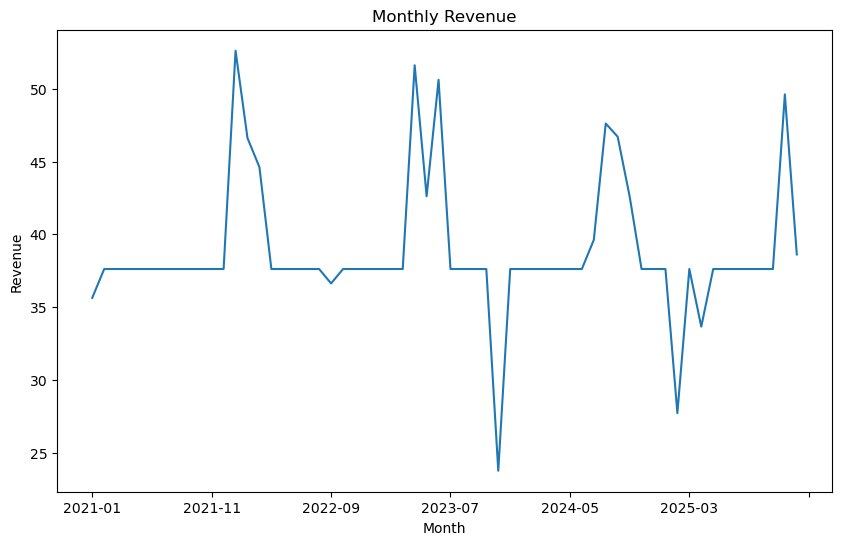

In [10]:
MonthlyRevenue['MonthlyRevenue'].plot(figsize=(10, 6), title='Monthly Revenue', legend=False)

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')

plt.show()

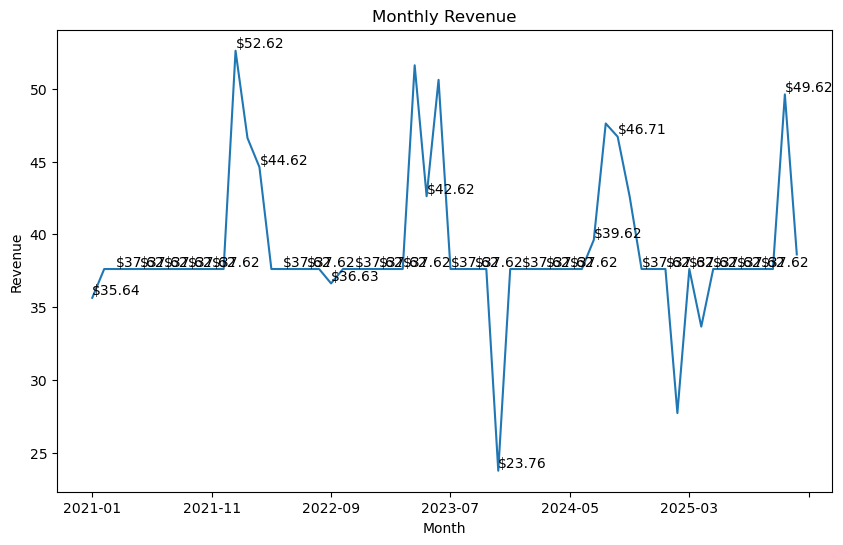

In [11]:
MonthlyRevenue['MonthlyRevenue'].plot(figsize=(10, 6), title='Monthly Revenue', legend=False)

plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')

# Add annotations (example - annotate every other point, adjust as needed)
for i, val in enumerate(MonthlyRevenue['MonthlyRevenue']):
    if i % 2 == 0: # Annotate every other point to avoid clutter
        plt.text(i, val, f'${val:.2f}', ha='left', va='bottom')

plt.show()

# Business Questions and Answers

## Question 2: If we want to hire a new employee, from which city should he be?

## Code - Query for Customer Count by City

In [12]:
city_customer_count= db_connection.execute_extract_query(
    """
    SELECT billing_city, COUNT(DISTINCT customer_id) AS customer_count
    FROM dw_schema.invoice_details
    GROUP BY billing_city
    ORDER BY customer_count DESC
    LIMIT 10; -- Showing top 10 cities
    """
)
city_customer_count_df=pd.DataFrame(city_customer_count,columns=['BillingCity','customer_count'])
city_customer_count_df.head(10)

,BillingCity,customer_count
0,Prague,2
1,London,2
2,Paris,2
3,São Paulo,2
4,Berlin,2
5,Mountain View,2
6,Brussels,1
7,Brasília,1
8,Chicago,1
9,Boston,1


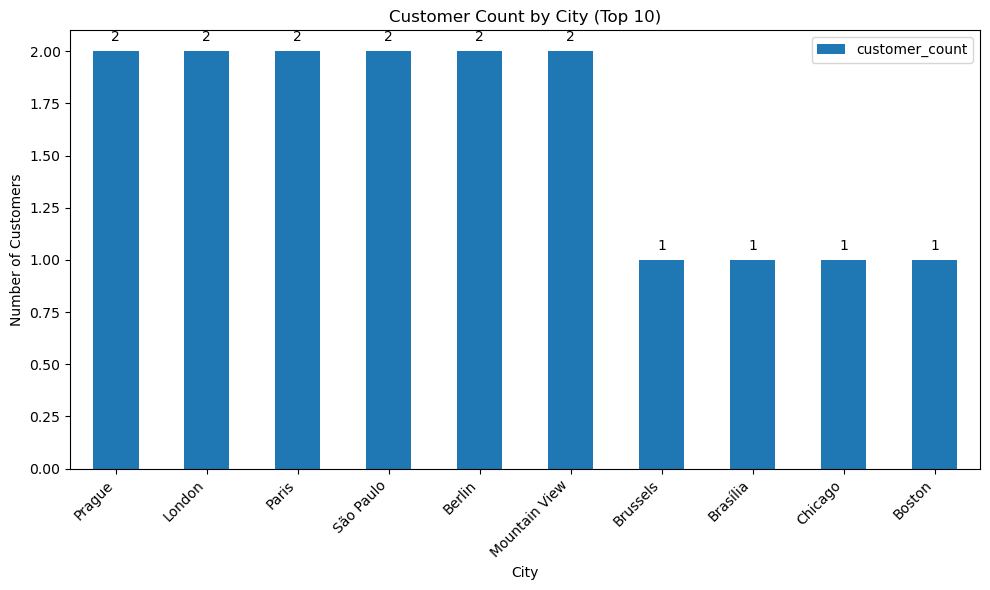

In [14]:
city_customer_count_df = city_customer_count_df.set_index('BillingCity')
ax = city_customer_count_df.plot(kind='bar', figsize=(10, 6)) # Store axes object

plt.title('Customer Count by City (Top 10)')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Add annotations to bars
for p in ax.patches: # ax.patches gets the bar objects
    height = p.get_height()
    ax.annotate(f'{height:.0f}',  # Format count as integer
                (p.get_x() + p.get_width() / 2., height), # X and Y coordinates for annotation
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points') # Adjust position of text

plt.show()

 ## Code - Bar Chart Visualization

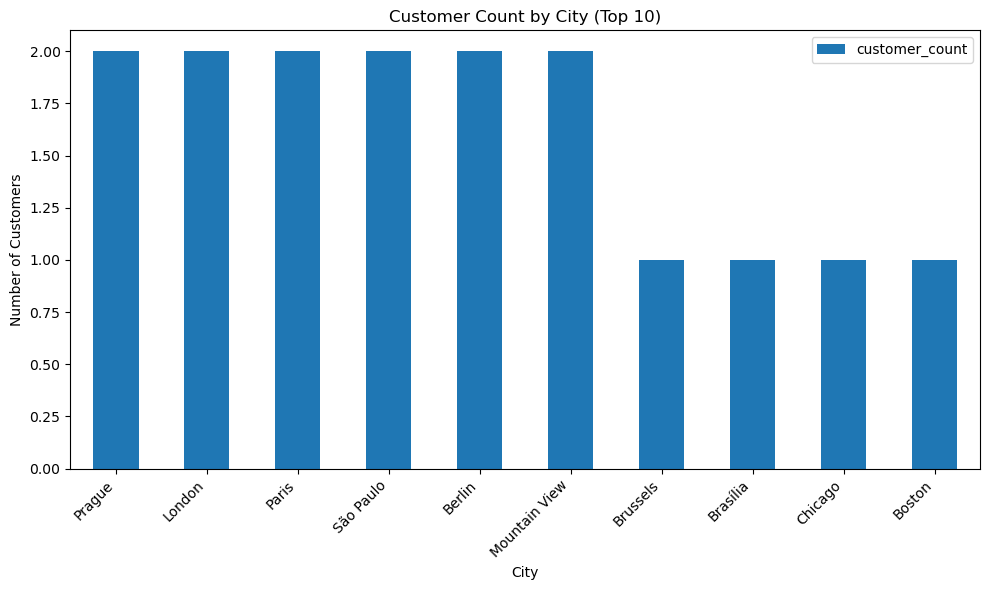

In [16]:
# city_customer_count_df.set_index('BillingCity', inplace=True)
city_customer_count_df.plot(kind='bar', figsize=(10, 6))
plt.title('Customer Count by City (Top 10)')
plt.xlabel('City')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right') # Rotate city names for better readability
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Question 3: In which period do sales increase?
## SQL Query for Monthly Revenue



In [17]:
# use db_connection.execute_extract_query(---#add your query here-----)
# then transform it into a Pandas DataFrame!
MonthlyRevenue= db_connection.execute_extract_query(
"""SELECT DATE_TRUNC('month', invoice_date) AS Month, SUM(total) AS MonthlyRevenue
FROM dw_schema.invoice_details
GROUP BY Month
ORDER BY Month;""")
MonthlyRevenue=pd.DataFrame(MonthlyRevenue,columns=['month','MonthlyRevenue'])
MonthlyRevenue.head()

,month,MonthlyRevenue
0,2021-01-01,35.64
1,2021-02-01,37.62
2,2021-03-01,37.62
3,2021-04-01,37.62
4,2021-05-01,37.62


## Transforming Data for Plotting

In [18]:
## transforming the data for plotting
MonthlyRevenue = MonthlyRevenue.set_index('month')
MonthlyRevenue.index = MonthlyRevenue.index.strftime('%Y-%m')
MonthlyRevenue['MonthlyRevenue'] = pd.to_numeric(MonthlyRevenue['MonthlyRevenue'], errors='coerce')
MonthlyRevenue.head()

,MonthlyRevenue
month,
2021-01,35.64
2021-02,37.62
2021-03,37.62
2021-04,37.62
2021-05,37.62


## Print Data Types

In [19]:
print(MonthlyRevenue.dtypes)

MonthlyRevenue    float64
dtype: object


## Question 4: Do older employees bring in more customers than newer employees?

In [51]:
# SQL Query to check if older employees bring in more customers
employee_customer_tenure = db_connection.execute_extract_query(
    """
    SELECT
        e.employee_id,
        e.first_name || ' ' || e.last_name AS employee_name,
        DATE_PART('year', e.hire_date) AS hire_year,
        COUNT(c.customer_id) AS customers_supported
    FROM dw_schema.employee e
    LEFT JOIN dw_schema.customer c ON e.employee_id = c.support_rep_id
    GROUP BY e.employee_id, employee_name, hire_year
    ORDER BY hire_year;
    """
)
employee_customer_tenure_df = pd.DataFrame(employee_customer_tenure, columns=['employee_id', 'employee_name', 'hire_year', 'customers_supported'])
employee_customer_tenure_df.head()

,employee_id,employee_name,hire_year,customers_supported
0,1,Andrew Adams,2002.0,0
1,2,Nancy Edwards,2002.0,0
2,3,Jane Peacock,2002.0,21
3,4,Margaret Park,2003.0,20
4,5,Steve Johnson,2003.0,18


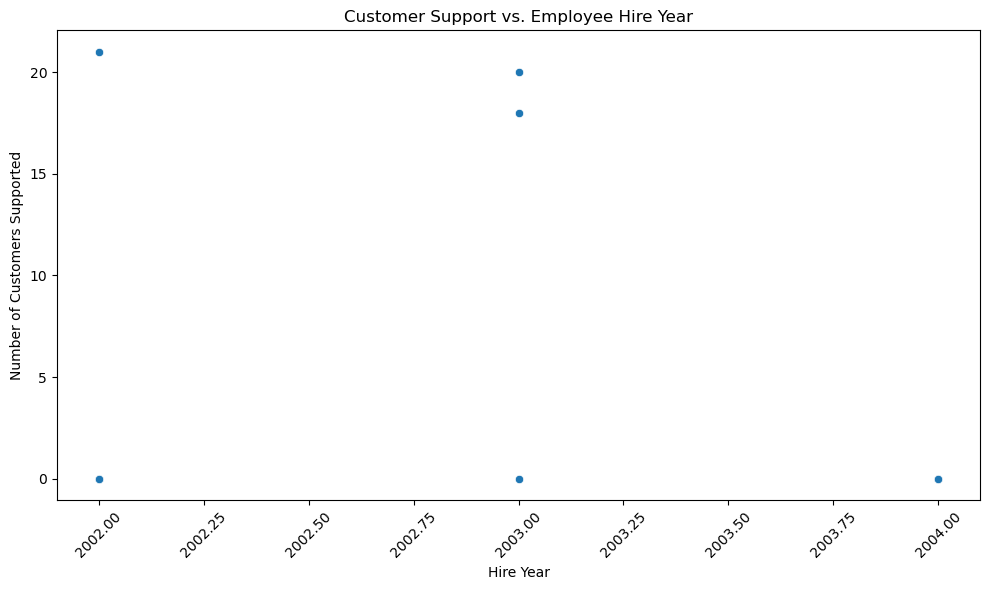

In [52]:
# Create a scatter plot to visualize the relationship
plt.figure(figsize=(10, 6))
sns.scatterplot(data=employee_customer_tenure_df, x='hire_year', y='customers_supported')
plt.title('Customer Support vs. Employee Hire Year')
plt.xlabel('Hire Year')
plt.ylabel('Number of Customers Supported')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Question 5: Which employees are the top sales performers?
## SQL Query for Employee Sales and DataFrame Creation

In [61]:
# SQL Query to find top sales employees (Snowflake Schema)
top_employee_sales = db_connection.execute_extract_query(
    """
    SELECT
        e.employee_id,
        e.first_name || ' ' || e.last_name AS employee_name,
        SUM(i.total) AS total_sales
    FROM dw_schema.employee e  -- Table name is dw_schema.employee_details
    LEFT JOIN dw_schema.customer c ON e.employee_id = c.support_rep_id
    LEFT JOIN dw_schema.invoice_details i ON c.customer_id = i.customer_id
    WHERE e.title LIKE '%Sales Support Agent%' -- Filter for Sales Support Agents
    GROUP BY e.employee_id, employee_name
    ORDER BY total_sales DESC
    LIMIT 5; -- Top 5 sales employees
    """
)
top_employee_sales_df = pd.DataFrame(top_employee_sales, columns=['employee_id', 'employee_name', 'total_sales'])
top_employee_sales_df.head()

,employee_id,employee_name,total_sales
0,3,Jane Peacock,833.04
1,4,Margaret Park,775.40
2,5,Steve Johnson,720.16


## Bar Chart Visualization for Top Employee Sales

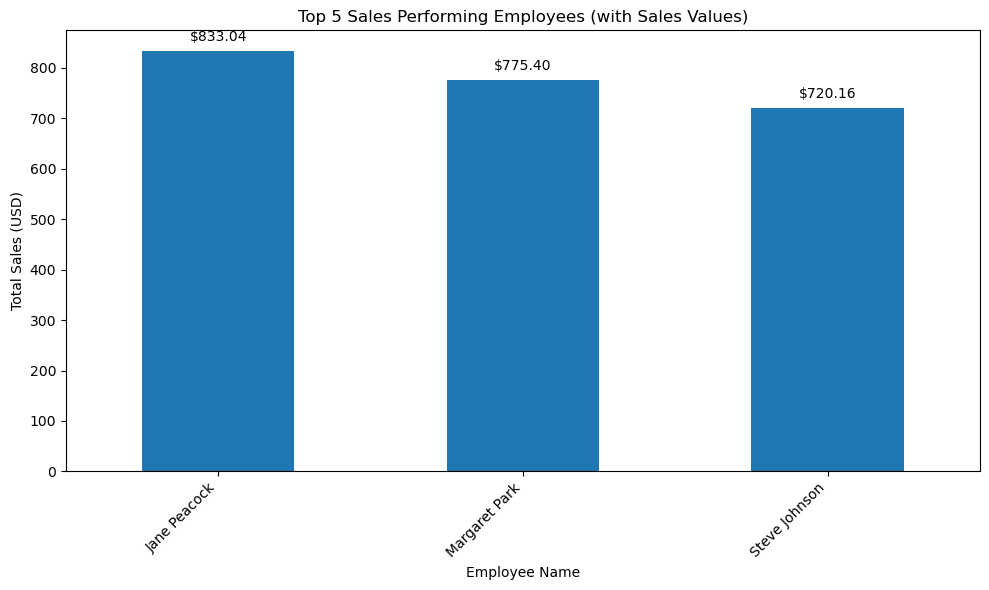

In [ ]:
top_employee_sales_df = top_employee_sales_df.set_index('employee_name')

ax = top_employee_sales_df['total_sales'].plot(kind='bar', figsize=(10, 6)) # Store axes object
plt.ylabel('Total Sales (USD)')
plt.xlabel('Employee Name')
plt.title('Top 5 Sales Performing Employees (with Sales Values)') # Updated title
plt.xticks(rotation=45, ha='right')
plt.legend().set_visible(False) # Disable legend
plt.tight_layout()

# Add annotations to bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'${height:.2f}', # Formatted as currency
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                xytext=(0, 5), textcoords='offset points')

plt.show()

## Question 6: What is the average purchase value of customers from different countries?

##  SQL Query for Average Purchase Value by Country and DataFrame Creation



In [43]:
# SQL Query to find average purchase value by customer country (Snowflake Schema)
avg_purchase_value_country = db_connection.execute_extract_query(
    """
    SELECT
        c.country AS customer_country,
        AVG(i.total) AS average_order_value
    FROM dw_schema.customer c
    JOIN dw_schema.invoice_details i ON c.customer_id = i.customer_id
    GROUP BY customer_country
    ORDER BY average_order_value DESC;
    """
)
avg_purchase_value_country_df = pd.DataFrame(avg_purchase_value_country, columns=['customer_country', 'average_order_value'])
avg_purchase_value_country_df.head()

,customer_country,average_order_value
0,Chile,1.2268421052631579
1,Hungary,1.2005263157894737
2,Ireland,1.2005263157894737
3,Czech Republic,1.1873684210526316
4,Austria,1.1215789473684211


## Question 7: Repeat Purchasers
### How many customers are repeat purchasers?

In [41]:
# SQL Query to count repeat customers (Snowflake Schema)
repeat_customer_count = db_connection.execute_extract_query(
    """
    SELECT COUNT(*) AS repeat_customer_count
    FROM (
        SELECT customer_id
        FROM dw_schema.invoice_details
        GROUP BY customer_id
        HAVING COUNT(*) > 1 -- Customers with more than one invoice
    ) AS repeat_customers;
    """
)
repeat_customer_count_df = pd.DataFrame(repeat_customer_count, columns=['repeat_customer_count'])
repeat_customer_count_df.head()

,repeat_customer_count
0,59


## Displaying Repeat Customer Count


In [42]:
# Display the count of repeat customers
num_repeat_customers = repeat_customer_count_df['repeat_customer_count'].iloc[0]

print(f"Number of repeat customers: {num_repeat_customers}")

Number of repeat customers: 59


## Question 8: What are the top 5 best-selling tracks overall?

                      name  total_sold
0              The Trooper           5
1     Hallowed Be Thy Name           4
2                 Eruption           4
3      Sure Know Something           4
4  The Number Of The Beast           4


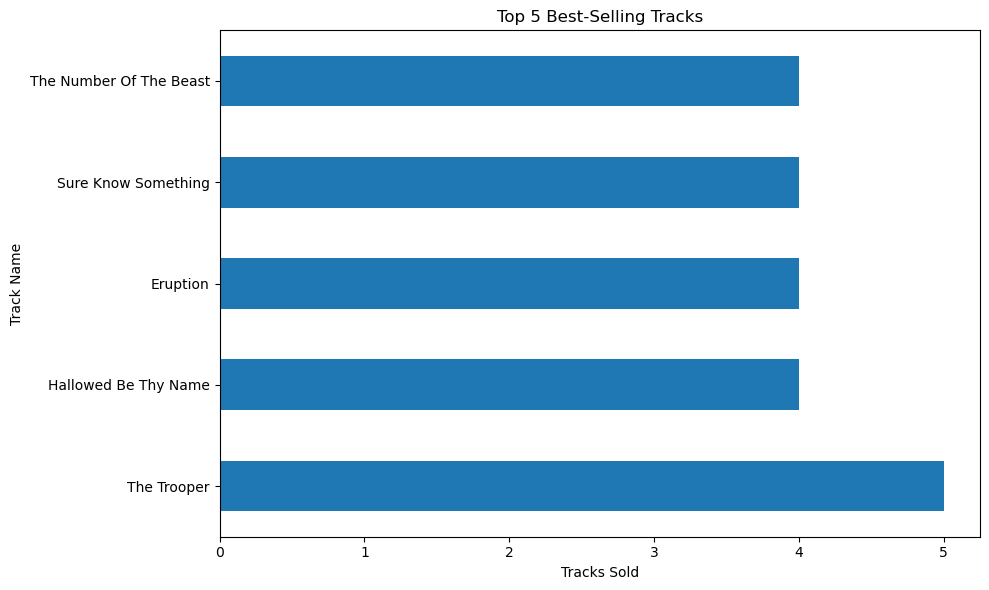

In [31]:
top_selling_tracks = db_connection.execute_extract_query(
    """
    SELECT
        name,
        COUNT(il.track_id) AS total_sold
    FROM dw_schema.track t
    JOIN dw_schema.invoice_details il ON t.track_id = il.track_id
    GROUP BY name
    ORDER BY total_sold DESC
    LIMIT 5; -- Top 5 best-selling tracks
    """
)
top_selling_tracks_df = pd.DataFrame(top_selling_tracks, columns=['name', 'total_sold'])
print(top_selling_tracks_df)

top_selling_tracks_df = top_selling_tracks_df.set_index('name')

top_selling_tracks_df['total_sold'].plot(kind='barh', figsize=(10, 6))
plt.xlabel('Tracks Sold')
plt.ylabel('Track Name')
plt.title('Top 5 Best-Selling Tracks')
plt.tight_layout()
plt.show()